# Setup

In [1]:
import requests
import re

from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline

## Scrape IMSLP

In [3]:
url = "http://imslp.org/wiki/List_of_works_by_Ludwig_van_Beethoven"

In [4]:
page = requests.get(url)

In [5]:
soup = BeautifulSoup(page.text, 'html.parser')

In [6]:
soup.head()

[<title>List of works by Ludwig van Beethoven - IMSLP/Petrucci Music Library: Free Public Domain Sheet Music</title>,
 <meta charset="utf-8"/>,
 <meta content="MediaWiki 1.18.1" name="generator"/>,
 <meta content="IE=edge" http-equiv="X-UA-Compatible"/>,
 <meta content="width=device-width, initial-scale=1, maximum-scale=1" name="viewport"/>,
 <link href="/apple-touch-icon.png" rel="apple-touch-icon" sizes="180x180"/>,
 <link href="/android-touch-icon.png" rel="icon" sizes="192x192"/>,
 <link href="/favicon.ico" rel="shortcut icon"/>,
 <link href="/opensearch_desc.php" rel="search" title="IMSLP (en)" type="application/opensearchdescription+xml"/>,
 <link href="//imslp.org/api.php?action=rsd" rel="EditURI" type="application/rsd+xml"/>,
 <link href="http://creativecommons.org/licenses/by-sa/4.0/" rel="copyright"/>,
 <link href="/index.php?title=Special:RecentChanges&amp;feed=atom" rel="alternate" title="IMSLP Atom feed" type="application/atom+xml"/>,
 <link href="/load.php?debug=false&amp

## Get table

In [7]:
table = soup.find("table")

In [8]:
table_text = []

for row in table.findAll("tr"):
    cells = row.findAll(["th", "td"])
    # Note: Already checked that all cells have length of 10
    cell_contents = [cell.text.replace("\n", "") for cell in cells] # Remove new line from each string in the process
    table_text.append(cell_contents)

In [9]:
raw_works = pd.DataFrame(table_text[1:], columns = table_text[0])

# Explore

In [10]:
print(raw_works.shape)
raw_works.head()

(557, 10)


,Op.,WoO,Hess,Biam-onti,Title,Key,Date,Scoring,Genre,Notes
0,001,—,—,062,Piano Trios (3):,,1792-94,vn vc pf,Chamber,
1,001/1,—,—,062/1,Piano Trio,E♭ major,1792-93,vn vc pf,Chamber,
2,001/2,—,—,062/2,Piano Trio,G major,1792-94,vn vc pf,Chamber,
3,001/3,—,—,062/3,Piano Trio,C minor,1792-94,vn vc pf,Chamber,arr. for 2vn va vc as Op.104
4,002,—,—,087,Piano Sonatas (3):,,1793-95,pf,Keyboard,


In [11]:
raw_works.sort_values("Date").head()

,Op.,WoO,Hess,Biam-onti,Title,Key,Date,Scoring,Genre,Notes
397,—,099,—,—,Italian Partsongs,,,,,
291,—,016,—,—,Ecossaises(12),,,orch,Orchestral,spurious
553,—,—,Anh. 10,—,Andante favori,F major,,2vn va vc,Chamber,arr. of WoO 57; Beethoven's authorship uncertain
544,—,Anh. 14,—,—,Waltzes (6),,,pf,Keyboard,spurious; authorship unknown
308,—,027,—,039,Duets (3),,,cl bn,Chamber,Beethoven's authorship doubtful; also arr. fo...


# Clean

In [12]:
df = raw_works.copy()

In [13]:
df.columns = [column.lower() for column in df.columns]

In [14]:
df.head()

,op.,woo,hess,biam-onti,title,key,date,scoring,genre,notes
0,001,—,—,062,Piano Trios (3):,,1792-94,vn vc pf,Chamber,
1,001/1,—,—,062/1,Piano Trio,E♭ major,1792-93,vn vc pf,Chamber,
2,001/2,—,—,062/2,Piano Trio,G major,1792-94,vn vc pf,Chamber,
3,001/3,—,—,062/3,Piano Trio,C minor,1792-94,vn vc pf,Chamber,arr. for 2vn va vc as Op.104
4,002,—,—,087,Piano Sonatas (3):,,1793-95,pf,Keyboard,


In [15]:
len(df[df["date"] == ""])

10

In [16]:
# Remove works without dates (unable to use in visualization)
df = df[df["date"] != ""]

Maybe the easiest way to get rid of these header-subheader type rows is to remove rows without keys. Plus, we can't really use a work if it happens not to have a key either...

But to know whether we're removing things because it's a heading or it's a piece that happens not to have a listed key, maybe regex ([0-9]) or something...

## Key

In [17]:
len(df[df["key"] == ""])

146

### Check out rows without keys

In [18]:
no_key = df[df["key"] == ""]

In [19]:
no_key[pd.isnull(no_key["title"])]

,op.,woo,hess,biam-onti,title,key,date,scoring,genre,notes


In [20]:
len(no_key[no_key["title"].apply(lambda x: bool(re.search(r"\([0-9]\)", x)))])

41

In [21]:
no_key[~no_key["title"].apply(lambda x: bool(re.search(r"\([0-9]\)", x)))].head()

,op.,woo,hess,biam-onti,title,key,date,scoring,genre,notes
65,032,—,—,421,"An die Hoffnung (""Die du so gern in heilgen N...",,1804-05,v pf,Vocal,1st setting; see also Op.94
77,043,—,—,288,Die Geschöpfe des Prometheus (The Creatures o...,,1800-01,orch,Stage,
120,065,—,—,116,Ah! Perfido,,1796,sop orch,Vocal,
129,072,—,109,423,"Fidelio (Leonore, oder Der Triumph der ehelic...",,1804-05,vv ch orch,Stage,1st version; includes Op. 72a
130,072,—,110,427,"Fidelio (Leonore, oder Der Triumph der ehelic...",,1805-06,vv ch orch,Stage,2nd version; includes Op. 72b (and WoO 2/2?)


Maybe next steps include going into each piece and getting the time or number of measures in a specific key (not the most practical considering rather stable formulas for certain musical forms, such as symphonies)

### Back to cleaning

In [22]:
# Anyway, let's go ahead and take out those without keys for our first pass trialing
df = df[df["key"] != ""]

In [23]:
len(df)

401

In [24]:
df["key"] = df["key"].str.replace("-flat", "♭")

In [25]:
df["key"] = df["key"].str.strip()

### Key distribution

In [26]:
print(df["key"].nunique())
df["key"].unique()

22


array(['E♭ major', 'G major', 'C minor', 'F minor', 'A major', 'C major',
       'F major', 'G minor', 'D major', 'B♭ major', 'E major', 'A minor',
       'A♭ major', 'C♯ minor', 'D minor', 'F♯ minor', 'E minor',
       'F♯ major', 'B♭ minor', 'C major-C minor', 'B minor',
       'A♭ major-D major'], dtype=object)

In [27]:
sorted(df["key"].unique())

['A major',
 'A minor',
 'A♭ major',
 'A♭ major-D major',
 'B minor',
 'B♭ major',
 'B♭ minor',
 'C major',
 'C major-C minor',
 'C minor',
 'C♯ minor',
 'D major',
 'D minor',
 'E major',
 'E minor',
 'E♭ major',
 'F major',
 'F minor',
 'F♯ major',
 'F♯ minor',
 'G major',
 'G minor']

In [28]:
len(df[df["key"] == "F♯ major"]) # 1
len(df[df["key"] == "B♭ minor"]) # 1

df[df["key"] == "B♭ minor"]

,op.,woo,hess,biam-onti,title,key,date,scoring,genre,notes
170,094,—,—,611,"An die Hoffnung (""Ob ein Gott sei?"")",B♭ minor,1813-15,v pf,Vocal,2nd setting; see Op.32


In [29]:
df.loc[df["key"] == "B♭ minor", "key"] = "E♭ major"

In [30]:
# Check
df[df["key"] == "B♭ minor"]

,op.,woo,hess,biam-onti,title,key,date,scoring,genre,notes


### Mode

In [31]:
def decide_key(key):
    if "major" in key:
        if "minor" not in key:
            return "major"
        else:
            return "other"
    elif "minor" in key:
        if "major" not in key:
            return "minor"
        else:
            return "other"
    else:
        return None

In [32]:
df["mode"] = df["key"].apply(decide_key)

## Date

In [33]:
df["date"].min(), df["date"].max()

(' -', ' —')

Well...

In [34]:
# Let's say we need to have date values with numbers
df[df["date"] == " -"]

,op.,woo,hess,biam-onti,title,key,date,scoring,genre,notes,mode
556,—,—,—,—,Hymne an die Nacht,C major,-,ch pf,Vocal,setting of theme from Op.57; Beethoven's auth...,major


In [35]:
# Strip this whitespace...?
df["date"] = df["date"].str.strip()

In [36]:
df[~df["date"].apply(lambda x: bool(re.search("[0-9]", x)))]

,op.,woo,hess,biam-onti,title,key,date,scoring,genre,notes,mode
118,063,—,Anh.14,II/65,Piano Trio,E♭ major,—,vn va vc,Chamber,arr. of Op.4; Beethoven's authorship doubtful,major
556,—,—,—,—,Hymne an die Nacht,C major,-,ch pf,Vocal,setting of theme from Op.57; Beethoven's auth...,major


In [37]:
# Yep, we can take those out
df = df[df["date"].apply(lambda x: bool(re.search("[0-9]", x)))]

In [38]:
df["date"].min(), df["date"].max()

('1782', '1826')

In [39]:
len(df)

399

In [40]:
# So how many of these are date ranges...
len(df[df["date"].str.contains("-")])

167

Dang, we need to find ways to decide... for now, let's keep a column for min and max dates

In [41]:
df["min_date"] = df["date"].apply(lambda x: x.split("-")[0] if "-" in x else x)
# Need to add the first two characters
df["max_date"] = df["date"].apply(lambda x: x[0:2] + x.split("-")[1] if "-" in x else x)
# Need to fix of turn of century exception
df["max_date"] = df["max_date"].apply(lambda x: x[2:] if len(x) == 6 else x) # 

In [42]:
df.head()

,op.,woo,hess,biam-onti,title,key,date,scoring,genre,notes,mode,min_date,max_date
1,001/1,—,—,062/1,Piano Trio,E♭ major,1792-93,vn vc pf,Chamber,,major,1792,1793
2,001/2,—,—,062/2,Piano Trio,G major,1792-94,vn vc pf,Chamber,,major,1792,1794
3,001/3,—,—,062/3,Piano Trio,C minor,1792-94,vn vc pf,Chamber,arr. for 2vn va vc as Op.104,minor,1792,1794
5,002/1,—,—,087/1,Piano Sonata No.1,F minor,1793-95,pf,Keyboard,,minor,1793,1795
6,002/2,—,—,087/2,Piano Sonata No.2,A major,1794-95,pf,Keyboard,,major,1794,1795


In [43]:
# Looks like there are question marks... let's just take these out too to resolve issues
df[df["date"].str.contains("\?")]

,op.,woo,hess,biam-onti,title,key,date,scoring,genre,notes,mode,min_date,max_date
271,—,002b,117,554,Prelude to Act II,D major,1805?,orch,Stage,now thought to be from the opening of Act II ...,major,1805?,1805?
347,—,053,066,159,Allegretto,C minor,1796-97 ?,pf,Keyboard,2nd version,minor,1796,97 ?
541,—,Anh. 04,—,—,Flute Sonata,B♭ major,1790-92 ?,fl pf,Chamber,Beethoven's authoship uncertain,major,1790,92 ?
543,—,Anh. 10,—,—,Variations on 'Ich hab ein kleines Hüttchen nur',B♭ major,1795 ?,pf,Keyboard,Beethoven's authorship is doubtful,major,1795 ?,95 ?


In [44]:
df = df[~df["date"].str.contains("\?")]

In [45]:
len(df)

395

### Further non-numeric purging

#### Failed attempts

Alright, let's find dates where there is something other than a number or "-"

In [46]:
df[(df["date"] != r"[0-9]*") | (df["date"] != r"[0-9]*-[0-9]*")].head()

,op.,woo,hess,biam-onti,title,key,date,scoring,genre,notes,mode,min_date,max_date
1,001/1,—,—,062/1,Piano Trio,E♭ major,1792-93,vn vc pf,Chamber,,major,1792,1793
2,001/2,—,—,062/2,Piano Trio,G major,1792-94,vn vc pf,Chamber,,major,1792,1794
3,001/3,—,—,062/3,Piano Trio,C minor,1792-94,vn vc pf,Chamber,arr. for 2vn va vc as Op.104,minor,1792,1794
5,002/1,—,—,087/1,Piano Sonata No.1,F minor,1793-95,pf,Keyboard,,minor,1793,1795
6,002/2,—,—,087/2,Piano Sonata No.2,A major,1794-95,pf,Keyboard,,major,1794,1795


Uh...

In [47]:
df[~df["date"].apply(lambda x: bool(re.match(r"[0-9]*-[0-9]*", x)))].head()

,op.,woo,hess,biam-onti,title,key,date,scoring,genre,notes,mode,min_date,max_date
8,003,—,—,105,String Trio,E♭ major,1794,vn va vc,Chamber,see also Op.64,major,1794,1794
9,004,—,—,115,String Quintet,E♭ major,1795,2vn 2va vc,Chamber,based on Op.103; see also Op.63,major,1795,1795
11,005/1,—,—,106/1,Cello Sonata No.1,F major,1796,vc pf,Chamber,,major,1796,1796
12,005/2,—,—,106/2,Cello Sonata No.2,G minor,1796,vc pf,Chamber,,minor,1796,1796
32,014/2,—,—,284,Piano Sonata No.10,G major,1799,pf,Keyboard,,major,1799,1799


Hmm...

In [48]:
df[~df["date"].str.match(r"[0-9]*-[0-9]*|[0-9]*")]

,op.,woo,hess,biam-onti,title,key,date,scoring,genre,notes,mode,min_date,max_date


#### Successful approach

Okay, let's switch up the approach

In [49]:
chars_to_match = [str(x) for x in list(range(10)) + ["-"]]

In [50]:
chars_to_match

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '-']

In [51]:
df[df["date"].apply(lambda x: any(char not in chars_to_match for char in x))]

,op.,woo,hess,biam-onti,title,key,date,scoring,genre,notes,mode,min_date,max_date
108,058,—,—,431,Piano Concerto No.4,G major,"1804-07, rev.1809",pf orch,Orchestral,arr. for 2vn va vc db pf as Op.58a,major,1804,"1807, rev.1809"
296,—,018,007,780,March ('Marsch für die bohmische Landwehr') (...,F major,1822 ca.,ww br perc,Orchestral,"3rd version, with trio and 'Turkish' orchestr...",major,1822 ca.,1822 ca.
299,—,019,009,781,March,F major,1822 ca.,ww br perc,Orchestral,"3rd version, with trio and 'Turkish' orchestr...",major,1822 ca.,1822 ca.
301,—,020,—,525,March ('Zapfenstreich') ('The Tattoo'),C major,1822 ca.,ww br perc,Orchestral,"2nd version, with trio",major,1822 ca.,1822 ca.


Keep these exceptions in mind... just use circas, though ignore multiple versions; just use ca. (circa)

In [52]:
df["min_date"] = df["min_date"].str.replace(" ca.", "")
df["max_date"] = df["max_date"].str.replace(" ca.", "")

In [53]:
df.loc[df["max_date"].str.contains("rev"), "max_date"] = 1807

### Convert to int

In [54]:
df["min_date"] = df["min_date"].apply(int)
df["max_date"] = df["max_date"].apply(int)
df["avg_date"] = (df["min_date"] + df["max_date"]) / 2

In [55]:
df.head()

,op.,woo,hess,biam-onti,title,key,date,scoring,genre,notes,mode,min_date,max_date,avg_date
1,001/1,—,—,062/1,Piano Trio,E♭ major,1792-93,vn vc pf,Chamber,,major,1792,1793,1792.5
2,001/2,—,—,062/2,Piano Trio,G major,1792-94,vn vc pf,Chamber,,major,1792,1794,1793.0
3,001/3,—,—,062/3,Piano Trio,C minor,1792-94,vn vc pf,Chamber,arr. for 2vn va vc as Op.104,minor,1792,1794,1793.0
5,002/1,—,—,087/1,Piano Sonata No.1,F minor,1793-95,pf,Keyboard,,minor,1793,1795,1794.0
6,002/2,—,—,087/2,Piano Sonata No.2,A major,1794-95,pf,Keyboard,,major,1794,1795,1794.5


# Differences by year?

## Min vs. max date (year) size

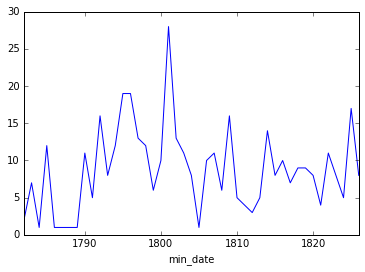

In [56]:
df.groupby("min_date").size().plot()

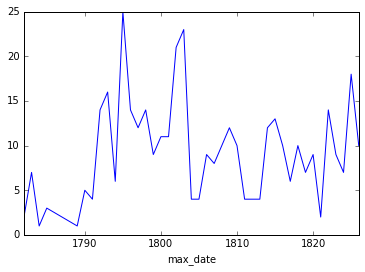

In [57]:
df.groupby("max_date").size().plot()

## Key

In [58]:
df.groupby("key")["avg_date"].mean().sort_values()

key
A♭ major-D major    1790.000000
G major             1800.392857
F♯ minor            1801.500000
C major-C minor     1802.000000
C minor             1802.739130
F minor             1803.000000
A major             1803.685185
D major             1804.053191
E♭ major            1804.578947
F major             1805.686047
E minor             1806.875000
C major             1807.061538
G minor             1807.071429
A minor             1808.166667
F♯ major            1809.000000
A♭ major            1809.500000
E major             1810.178571
B♭ major            1810.863636
C♯ minor            1813.250000
D minor             1814.388889
B minor             1821.000000
Name: avg_date, dtype: float64

## Mode

In [59]:
df.groupby("mode")["avg_date"].agg([np.mean, np.size])

,mean,size
mode,,
major,1805.403904,333.0
minor,1806.418033,61.0
other,1802.000000,1.0


In [60]:
df.groupby("mode")["min_date"].agg([np.mean, np.size])

,mean,size
mode,,
major,1804.825826,333
minor,1805.754098,61
other,1802.000000,1


In [61]:
df.groupby("mode")["max_date"].agg([np.mean, np.size])

,mean,size
mode,,
major,1805.981982,333
minor,1807.081967,61
other,1802.000000,1


# Plot (average date)? 

In [62]:
size_df = pd.DataFrame(df[df["mode"] != "other"].groupby(["mode", "avg_date"]).size()).reset_index().rename(columns={0:"size"})

In [63]:
cumsum_col = size_df.groupby("mode")["size"].cumsum()

In [64]:
size_df["cumsum"] = cumsum_col

In [65]:
size_df.head()

,mode,avg_date,size,cumsum
0,major,1782.0,1,1
1,major,1783.0,6,7
2,major,1784.0,1,8
3,major,1785.0,3,11
4,major,1788.0,2,13


In [66]:
size_df.tail()

,mode,avg_date,size,cumsum
102,minor,1821.5,1,54
103,minor,1824.0,2,56
104,minor,1825.0,3,59
105,minor,1825.5,1,60
106,minor,1826.0,1,61


mode
major    Axes(0.125,0.125;0.775x0.775)
minor    Axes(0.125,0.125;0.775x0.775)
dtype: object

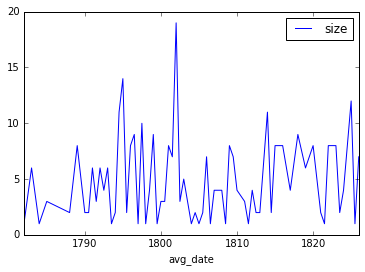

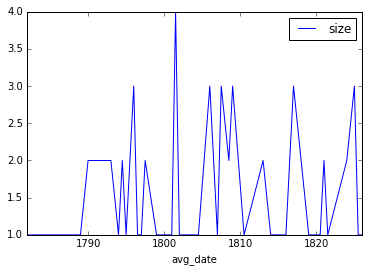

In [67]:
size_df.groupby("mode").plot(x="avg_date", y="size")

## Pivot table approach

In [68]:
pivoted = pd.pivot_table(size_df, values='size', columns='mode', index='avg_date').fillna(0)

Looks like having a low sample (missing years/years of 0) and taking midpoint years is complicated graphing...

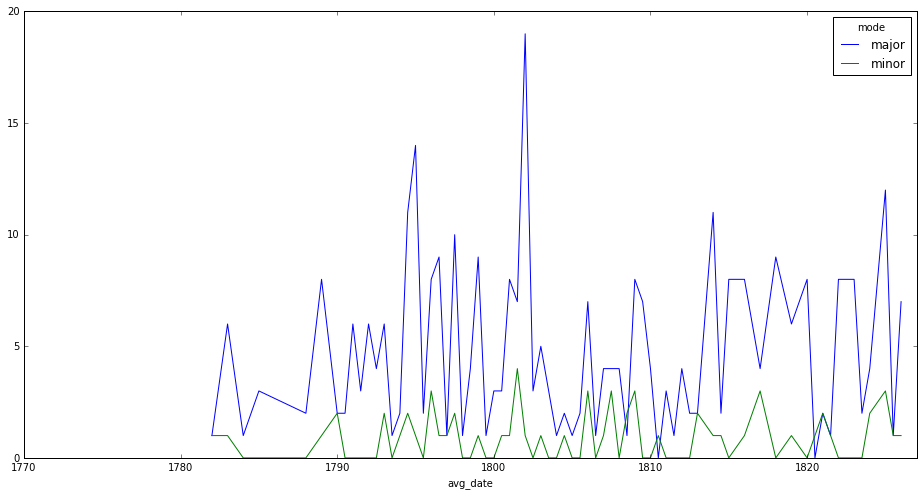

In [69]:
pivoted.plot(figsize = (16, 8), xlim = [1770, 1827])

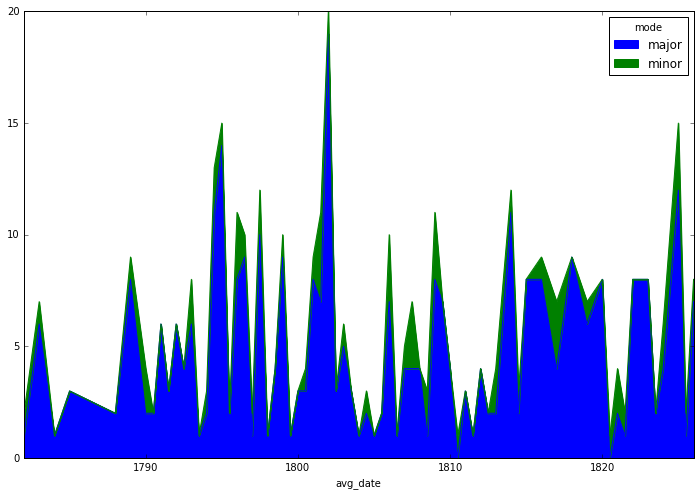

In [70]:
pivoted.plot(kind = "area", figsize = (12, 8))

In [71]:
pivoted_cumsum = pd.pivot_table(size_df, values='cumsum', columns='mode', index='avg_date').fillna(0)

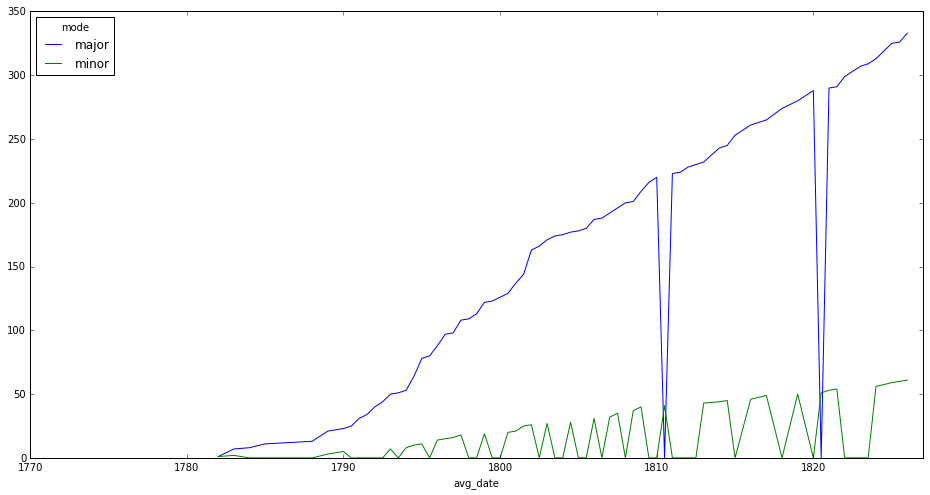

In [72]:
pivoted_cumsum.plot(figsize = (16, 8), xlim = [1770, 1827])

Yikes, 0 values

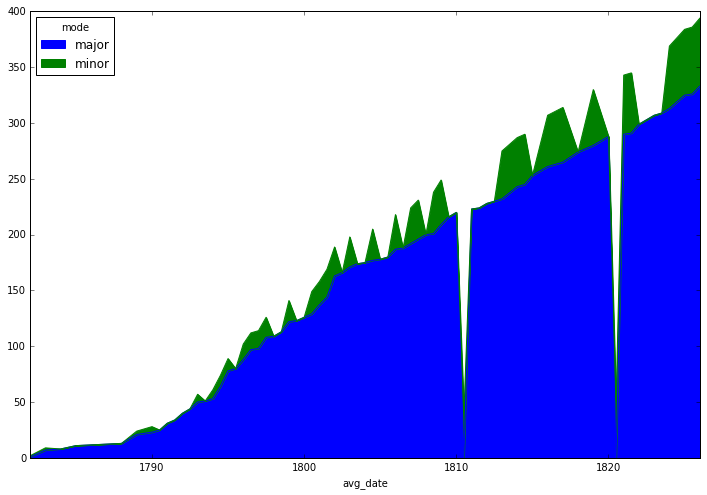

In [73]:
pivoted_cumsum.plot(kind = "area", figsize = (12, 8))

# Plot (max date)? 

In [146]:
size_df = pd.DataFrame(df[df["mode"] != "other"].groupby(["mode", "max_date"]).size()).reset_index().rename(columns={0:"size"})

In [147]:
cumsum_col = size_df.groupby("mode")["size"].cumsum()

In [148]:
size_df["cumsum"] = cumsum_col

In [149]:
size_df.head()

,mode,max_date,size,cumsum
0,major,1782,1,1
1,major,1783,6,7
2,major,1784,1,8
3,major,1785,3,11
4,major,1789,1,12


In [150]:
size_df.tail()

,mode,max_date,size,cumsum
67,minor,1821,2,51
68,minor,1822,2,53
69,minor,1824,2,55
70,minor,1825,4,59
71,minor,1826,2,61


mode
major    Axes(0.125,0.125;0.775x0.775)
minor    Axes(0.125,0.125;0.775x0.775)
dtype: object

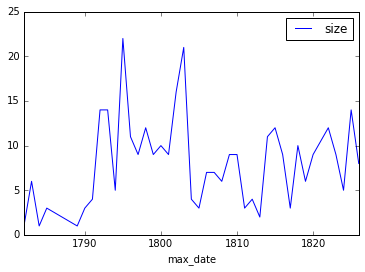

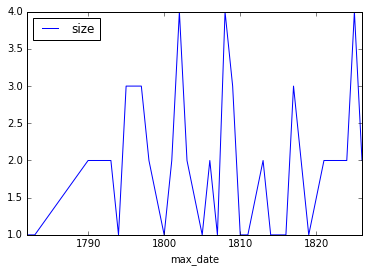

In [151]:
size_df.groupby("mode").plot(x="max_date", y="size")

## Pivot table approach

In [152]:
pivoted = pd.pivot_table(size_df, values='size', columns='mode', index='max_date').fillna(0)

Looks like having a low sample (missing years/years of 0) and taking midpoint years is complicated graphing...

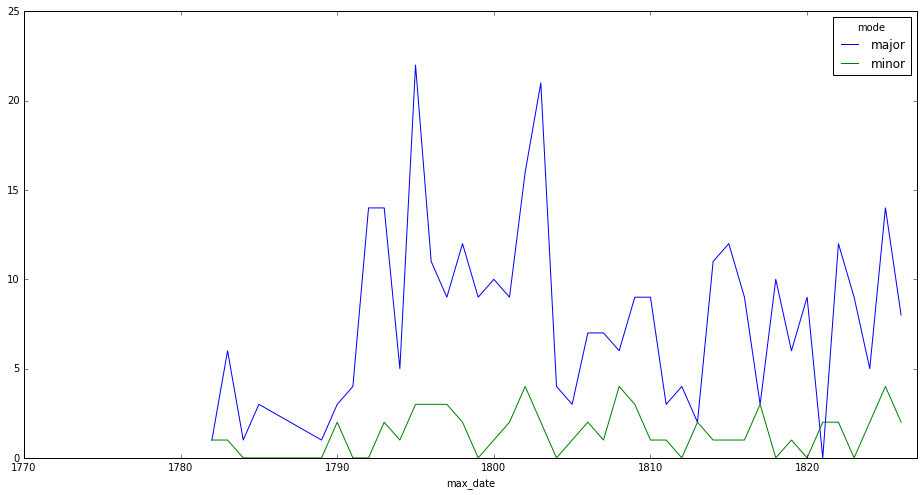

In [153]:
pivoted.plot(figsize = (16, 8), xlim = [1770, 1827])

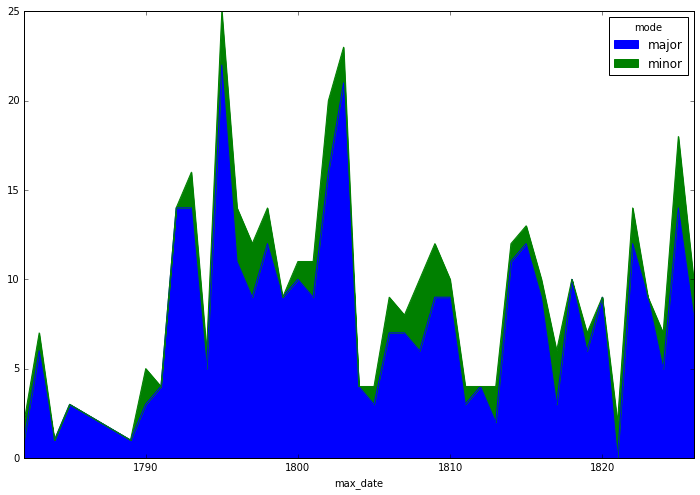

In [154]:
pivoted.plot(kind = "area", figsize = (12, 8))

In [155]:
pivoted_cumsum = pd.pivot_table(size_df, values='cumsum', columns='mode', index='max_date').fillna(0)

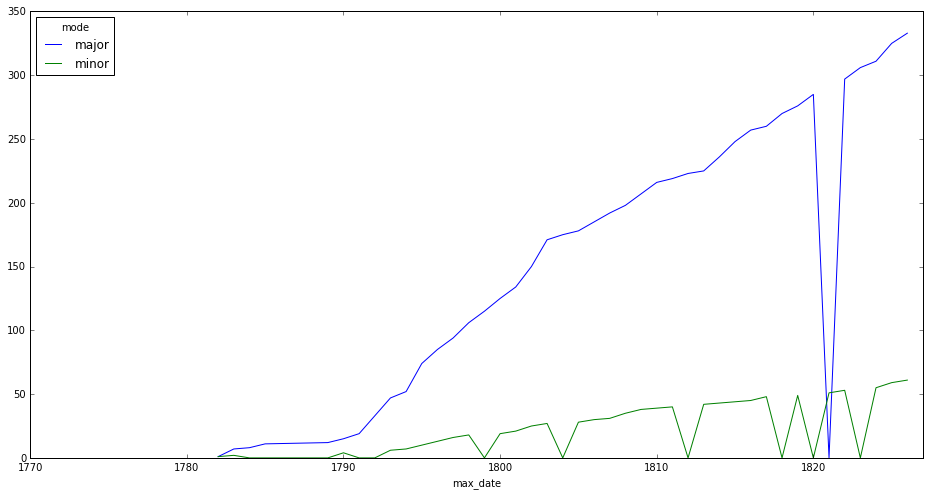

In [156]:
pivoted_cumsum.plot(figsize = (16, 8), xlim = [1770, 1827])

Yikes, 0 values

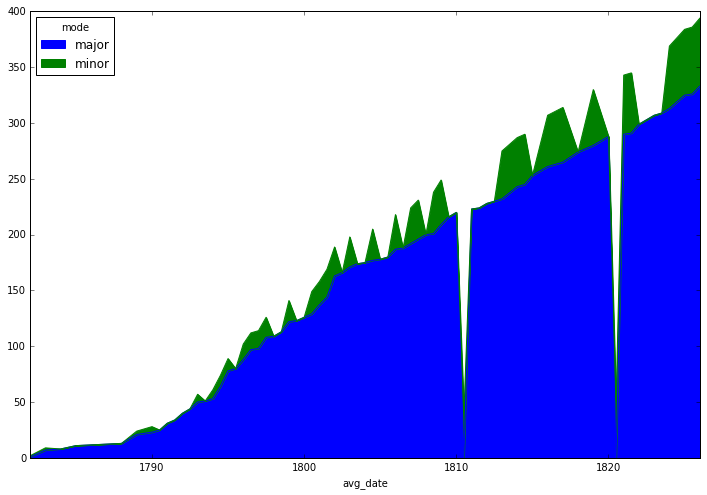

In [73]:
pivoted_cumsum.plot(kind = "area", figsize = (12, 8))

Not really interested in pursuing these kinds of plots (kind of looks like a stegosaurus...), so not going to bother to fix these for now.

# More cleaning

## Add periods in

Let's order by Biamonti, since it's chronological.

In [78]:
df = df.sort_values("biam-onti")

In [84]:
df["title"] = df["title"].str.strip()

In [88]:
# Reset index to make mass editing easier
df.reset_index(drop=True, inplace=True)

http://www.lcsproductions.net/MusicHistory/MusHistRev/Articles/BeethvnPeriods.html

In [89]:
# Let's start pre-First period; start with Piano Trios

In [90]:
df.loc[df["title"] == "Piano Trio"]

,op.,woo,hess,biam-onti,title,key,date,scoring,genre,notes,mode,min_date,max_date,avg_date
53,001/1,—,—,062/1,Piano Trio,E♭ major,1792-93,vn vc pf,Chamber,,major,1792,1793,1792.5
54,001/2,—,—,062/2,Piano Trio,G major,1792-94,vn vc pf,Chamber,,major,1792,1794,1793.0
55,001/3,—,—,062/3,Piano Trio,C minor,1792-94,vn vc pf,Chamber,arr. for 2vn va vc as Op.104,minor,1792,1794,1793.0
232,070/2,—,—,455/2,Piano Trio,E♭ major,1808,vn vc pf,Chamber,,major,1808,1808,1808.0


In [95]:
df.loc[0:52, "period"] = "pre"

In [96]:
# First period ends with "Pastoral" Piano Sonata

,op.,woo,hess,biam-onti,title,key,date,scoring,genre,notes,mode,min_date,max_date,avg_date,period
0,—,063,—,001,Variations on a March by Dressler (9),C minor,1782,pf,Chamber,based on a march by Ernst Christoph Dressler,minor,1782,1782,1782.0,pre
1,—,047/1,—,002/1,Piano Sonata,E♭ major,1783,pf,Keyboard,,major,1783,1783,1783.0,pre
2,—,047/2,—,002/2,Piano Sonata,F minor,1783,pf,Keyboard,,minor,1783,1783,1783.0,pre
3,—,047/3,—,002/3,Piano Sonata,D major,1783,pf,Keyboard,,major,1783,1783,1783.0,pre
4,—,048,051,004,Rondo,C major,1783,pf,Keyboard,,major,1783,1783,1783.0,pre
5,—,049,—,005,Rondo,A major,1783,pf,Keyboard,,major,1783,1783,1783.0,pre
6,—,031,—,006,Fugue,D major,1783,org,Keyboard,,major,1783,1783,1783.0,pre
7,—,107,—,007,"Schilderung eines Mädchens(""Schildern, willst ...",G major,1782,v pf,Vocal,,major,1782,1782,1782.0,pre
8,—,108,—,009,"An einen Säugling (""Noch weisst du nicht, wes ...",A major,1783,v pf,Vocal,,major,1783,1783,1783.0,pre
9,—,004,—,010,Piano Concerto,E♭ major,1784,pf orch,Orchestral,only pf part survives; completed by Willy Hess,major,1784,1784,1784.0,pre


In [97]:
df.loc[df["title"] == "Violin Sonata No.5"]

,op.,woo,hess,biam-onti,title,key,date,scoring,genre,notes,mode,min_date,max_date,avg_date,period
156,024,—,—,294,Violin Sonata No.5,F major,1800-01,vn pf,Chamber,,major,1800,1801,1800.5,NaN


In [128]:
df.loc[53:196, "period"] = "first"

Avoiding transition because second transition very unclear...

In [114]:
# df.loc[157:196, "period"] = "first transition"

In [112]:
df.loc[df["title"] == "Symphony No.3 ('Eroica')"]

,op.,woo,hess,biam-onti,title,key,date,scoring,genre,notes,mode,min_date,max_date,avg_date,period
197,055,—,—,406,Symphony No.3 ('Eroica'),E♭ major,1803,orch,Orchestral,,major,1803,1803,1803.0,NaN


In [115]:
df.loc[df["title"] == "Egmont"] # removed because no key

,op.,woo,hess,biam-onti,title,key,date,scoring,genre,notes,mode,min_date,max_date,avg_date,period


In [121]:
df.loc[df["title"] == "Fidelio, opera in 2 acts"] # removed because no key

,op.,woo,hess,biam-onti,title,key,date,scoring,genre,notes,mode,min_date,max_date,avg_date,period


In [122]:
df.loc[df["title"] == "Piano Sonata No.27"]

,op.,woo,hess,biam-onti,title,key,date,scoring,genre,notes,mode,min_date,max_date,avg_date,period
275,090,—,—,578,Piano Sonata No.27,E minor,1814,pf,Keyboard,,minor,1814,1814,1814.0,NaN


In [124]:
df.loc[197:275, "period"] = "second"

In [126]:
df.loc[276:, "period"] = "third"

In [162]:
# Remove non-Biamonti works
df = df.loc[:389]

In [163]:
df.groupby("period").size()

period
first     144
pre        53
second     79
third     114
dtype: int64

# Minor by period

In [164]:
df[df["mode"] == "minor"].groupby("period").size() / df.groupby("period").size()

period
first     0.145833
pre       0.113208
second    0.227848
third     0.131579
dtype: float64

## C minor? (and other minor keys)

https://en.wikipedia.org/wiki/Beethoven_and_C_minor

In [165]:
(df["key"] == "C minor").sum(), len(df)

(23, 390)

In [166]:
df[df["key"] == "C minor"].groupby("period").size()

period
first     11
pre        3
second     5
third      4
dtype: int64

The works by Beethoven in C minor hardly exhaust the set of emotionally stormy minor-key works by this composer; some useful comparisons would include the piano sonatas Op. 2, No. 1 and Op. 57 (both in F minor), the String Quartet, Op. 95 (also in F minor), the fourth movement of the "Pastoral" Symphony (again in F minor), the final movements of Beethoven's only two pieces in C♯ minor (the "Moonlight" Sonata and the String Quartet, Op. 131), and two of his most famous D-minor works: the "Tempest" Sonata and the Ninth Symphony (whose slow movements, like that of many of his C-minor works, are in the subdominant parallel).

In [167]:
df[df["key"] == "F minor"].groupby("period").size()

period
first     2
pre       2
second    3
dtype: int64

In [168]:
df[df["key"] == "C♯ minor"].groupby("period").size()

period
first    1
third    1
dtype: int64

In [169]:
df[df["key"] == "D minor"].groupby("period").size()

period
first     1
second    2
third     6
dtype: int64

# Save

Need to strip all whitespace...

In [186]:
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [188]:
df.head()

,op.,woo,hess,biam-onti,title,key,date,scoring,genre,notes,mode,min_date,max_date,avg_date,period
0,—,063,—,001,Variations on a March by Dressler (9),C minor,1782,pf,Chamber,based on a march by Ernst Christoph Dressler,minor,1782,1782,1782.0,pre
1,—,047/1,—,002/1,Piano Sonata,E♭ major,1783,pf,Keyboard,,major,1783,1783,1783.0,pre
2,—,047/2,—,002/2,Piano Sonata,F minor,1783,pf,Keyboard,,minor,1783,1783,1783.0,pre
3,—,047/3,—,002/3,Piano Sonata,D major,1783,pf,Keyboard,,major,1783,1783,1783.0,pre
4,—,048,051,004,Rondo,C major,1783,pf,Keyboard,,major,1783,1783,1783.0,pre


In [192]:
df.rename(columns={"biam-onti": "biamonti"}, inplace=True)

In [193]:
# df.to_csv("cleaned_imslp.csv", index = False)